In [1]:
# Cell 1: Imports and setup
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from groundingdino.util.inference import load_model, predict
import matplotlib.pyplot as plt

print("Imports successful!")

/isis/home/hasana3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [15]:
# Cell 2: Load the model
model = load_model(
    "../groundingdino/config/GroundingDINO_SwinB_cfg.py",
    "/isis/home/hasana3/vlmtest/GroundingDINO/output/visdrone_swinb_finetune_no_backbone_training/checkpoint_best_regular.pth"
).cuda()

print("Model loaded!")

final text_encoder_type: bert-base-uncased
Model loaded!


Image shape: (1530, 2720, 3)
Image dtype: uint8
Image min/max: 0/255


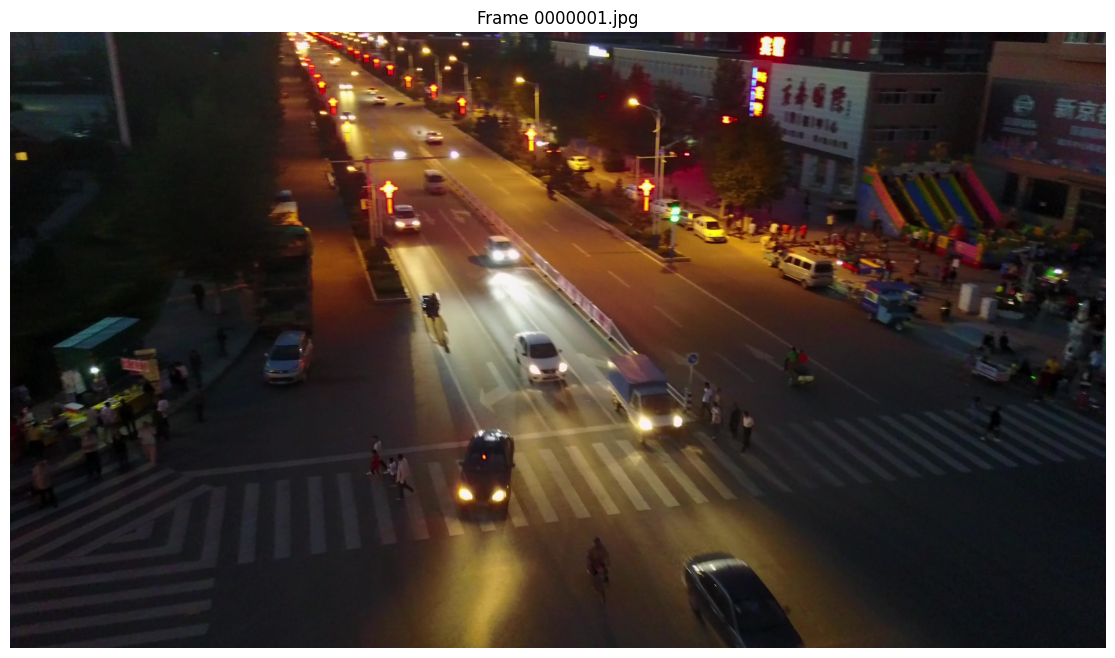

In [17]:
# Cell 3: Load and inspect the image
img_path = "../dataset/visdrone_mot_format/val/uav0000117_02622_v/img1/0000101.jpg"
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print(f"Image shape: {img_bgr.shape}")
print(f"Image dtype: {img_bgr.dtype}")
print(f"Image min/max: {img_bgr.min()}/{img_bgr.max()}")

# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(img_rgb)
plt.title("Frame 0000001.jpg")
plt.axis('off')
plt.show()

In [18]:
# Cell 4: Check ground truth for this frame
with open("../dataset/visdrone_mot_format/val/uav0000117_02622_v/gt/gt.txt") as f:
    frame1_gt = [line for line in f if line.startswith("1,")]
    
print(f"Ground truth objects in frame 1: {len(frame1_gt)}")
print("First 5 GT lines:")
for line in frame1_gt[:5]:
    print(line.strip())

Ground truth objects in frame 1: 19
First 5 GT lines:
1,0,1649.00,598.00,39.00,93.00,1,-1,-1,-1
1,1,1631.00,607.00,33.00,84.00,1,-1,-1,-1
1,2,1658.00,625.00,60.00,93.00,1,-1,-1,-1
1,3,1589.00,595.00,53.00,80.00,1,-1,-1,-1
1,23,443.00,754.00,147.00,156.00,1,-1,-1,-1


In [19]:
# Cell 5: Transform and run detection
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_pil = Image.fromarray(img_rgb)
tensor = transform(img_pil).cuda()

print(f"Tensor shape: {tensor.shape}")

Tensor shape: torch.Size([3, 1530, 2720])


In [20]:
# Cell 6: Test with different prompts and thresholds
prompts = [
    "pedestrian. car. van. bus. truck.",
    "person. vehicle.",
    "object.",
]

for prompt in prompts:
    print(f"\n{'='*50}")
    print(f"Prompt: {prompt}")
    print('='*50)
    
    boxes, logits, phrases = predict(
        model=model,
        image=tensor,
        caption=prompt,
        box_threshold=0.01,
        text_threshold=0.01
    )
    
    print(f"Detections found: {len(boxes)}")
    if len(boxes) > 0:
        print(f"Top 5 scores: {logits[:5].tolist()}")
        print(f"Top 5 phrases: {phrases[:5]}")
        print(f"Sample boxes (normalized): {boxes[:2].tolist()}")


Prompt: pedestrian. car. van. bus. truck.
Detections found: 900
Top 5 scores: [0.03131560608744621, 0.046024490147829056, 0.037365563213825226, 0.0655125305056572, 0.05058079957962036]
Top 5 phrases: ['pedestrian car van truck', 'pedestrian car van bus truck', 'pedestrian car van bus truck', 'pedestrian car van bus truck', 'pedestrian car van bus truck']
Sample boxes (normalized): [[0.34097328782081604, 0.043186742812395096, 0.026261981576681137, 0.09934461861848831], [0.36495769023895264, 0.050082750618457794, 0.03520214557647705, 0.11083244532346725]]

Prompt: person. vehicle.
Detections found: 900
Top 5 scores: [0.011893630027770996, 0.020611202344298363, 0.027276823297142982, 0.02634594589471817, 0.03003721497952938]
Top 5 phrases: ['vehicle', 'person vehicle', 'person vehicle', 'person vehicle', 'person vehicle']
Sample boxes (normalized): [[0.34673643112182617, 0.04643353074789047, 0.028033291921019554, 0.14320363104343414], [0.35355597734451294, 0.04705357924103737, 0.023110708

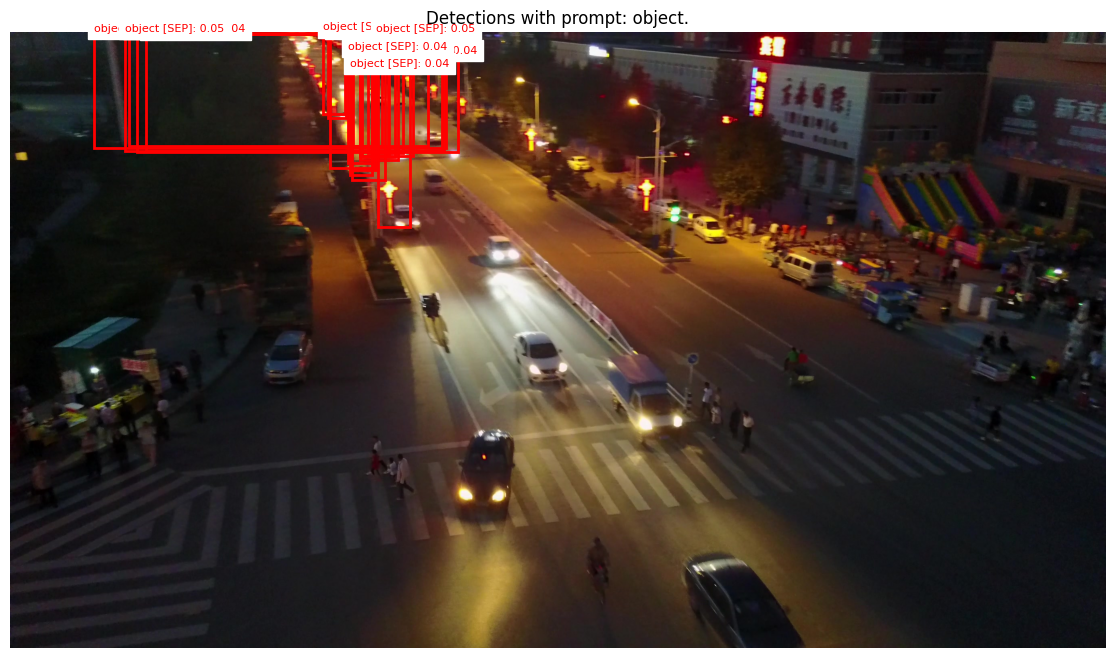

In [22]:
# Cell 7: Visualize detections (if any found)
# Use the last prompt's results
if len(boxes) > 0:
    H, W = img_rgb.shape[:2]
    
    fig, ax = plt.subplots(1, figsize=(15, 8))
    ax.imshow(img_rgb)
    
    for box, score, phrase in zip(boxes[:20], logits[:20], phrases[:20]):
        cx, cy, w, h = box
        x1 = (cx - w/2) * W
        y1 = (cy - h/2) * H
        x2 = (cx + w/2) * W
        y2 = (cy + h/2) * H
        
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{phrase}: {score:.2f}", 
               color='red', fontsize=8, backgroundcolor='white')
    
    plt.title(f"Detections with prompt: {prompt}")
    plt.axis('off')
    plt.show()
else:
    print("No detections to visualize!")

Testing with box_thresh=0.01
Detections found: 900
Score range: 0.018 to 0.093
Unique phrases: {'pedestrian car person vehicle', 'pedestrian car van bus truck person vehicle', 'pedestrian car van truck person vehicle', 'pedestrian car truck person vehicle', 'pedestrian car van bus truck person vehicle [SEP]', 'pedestrian car truck vehicle', 'pedestrian vehicle'}


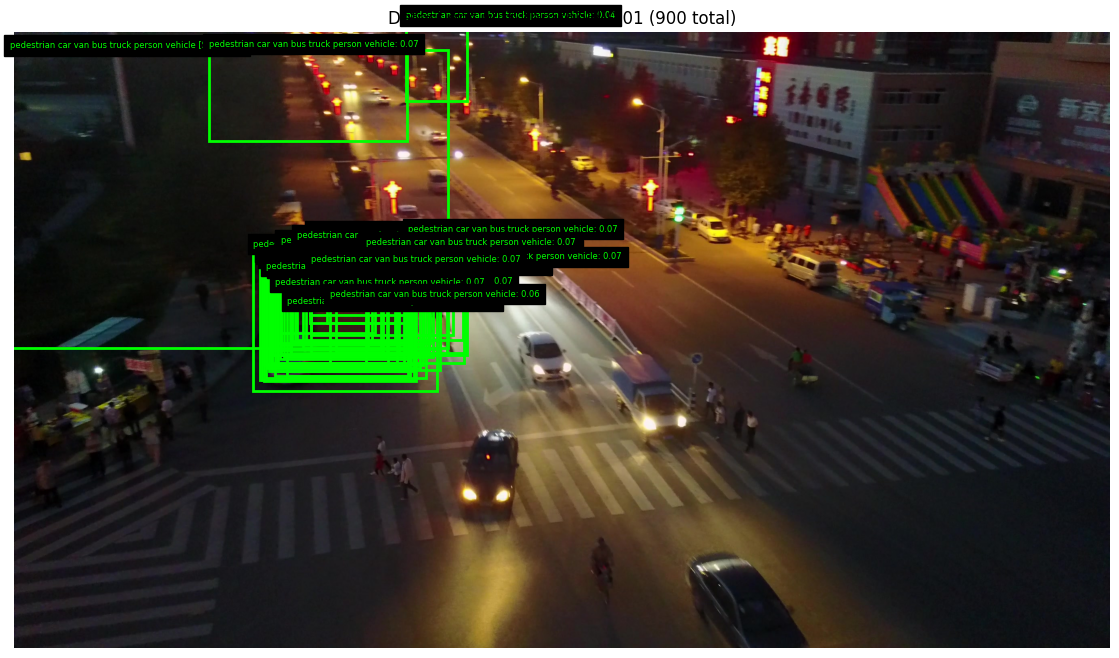

In [23]:
# Cell 8: Test with ultra-low threshold
print("Testing with box_thresh=0.01")
boxes, logits, phrases = predict(
    model=model,
    image=tensor,
    caption="pedestrian. car. van. bus. truck. person. vehicle.",
    box_threshold=0.01,  # Even lower
    text_threshold=0.01
)

print(f"Detections found: {len(boxes)}")
if len(boxes) > 0:
    print(f"Score range: {logits.min():.3f} to {logits.max():.3f}")
    print(f"Unique phrases: {set(phrases)}")
    
    # Visualize
    H, W = img_rgb.shape[:2]
    fig, ax = plt.subplots(1, figsize=(15, 8))
    ax.imshow(img_rgb)
    
    for box, score, phrase in zip(boxes[:50], logits[:50], phrases[:50]):
        cx, cy, w, h = box
        x1, y1 = (cx - w/2) * W, (cy - h/2) * H
        x2, y2 = (cx + w/2) * W, (cy + h/2) * H
        
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                             fill=False, color='lime', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{phrase}: {score:.2f}", 
               color='lime', fontsize=6, backgroundcolor='black')
    
    plt.title(f"Detections with threshold 0.01 ({len(boxes)} total)")
    plt.axis('off')
    plt.show()

Ground Truth boxes in frame 1: 19
DINO detections (threshold 0.01): 900


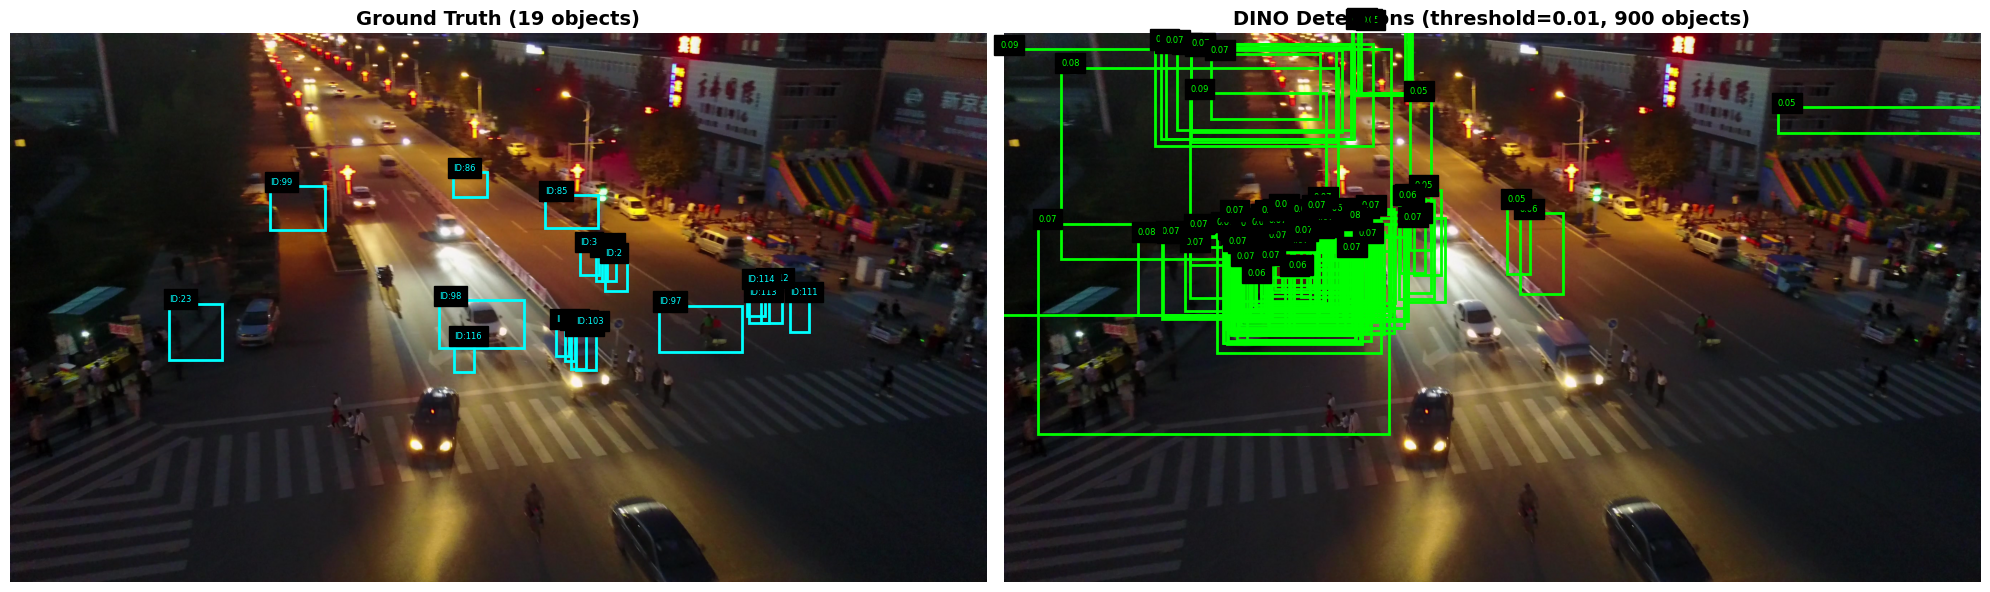


STATISTICS
GT boxes: 19
DINO detections: 900
Detection rate: 4736.8%

DINO score range: 0.0181 to 0.0928
Mean score: 0.0565


In [24]:
# Cell 9: Visualize Ground Truth vs Detections
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Parse GT for frame 1
gt_boxes = []
with open("../dataset/visdrone_mot_format/val/uav0000117_02622_v/gt/gt.txt") as f:
    for line in f:
        parts = line.strip().split(',')
        frame_id = int(parts[0])
        if frame_id == 1:
            track_id = int(parts[1])
            x, y, w, h = map(float, parts[2:6])
            gt_boxes.append([x, y, w, h, track_id])

print(f"Ground Truth boxes in frame 1: {len(gt_boxes)}")
print(f"DINO detections (threshold 0.01): {len(boxes)}")

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Ground Truth
axes[0].imshow(img_rgb)
axes[0].set_title(f'Ground Truth ({len(gt_boxes)} objects)', fontsize=14, fontweight='bold')
for box in gt_boxes[:100]:  # Limit to 100 for visibility
    x, y, w, h, tid = box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                             edgecolor='cyan', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].text(x, y-5, f"ID:{int(tid)}", color='cyan', 
                fontsize=6, backgroundcolor='black')
axes[0].axis('off')

# Right: DINO Detections
axes[1].imshow(img_rgb)
axes[1].set_title(f'DINO Detections (threshold=0.01, {len(boxes)} objects)', 
                 fontsize=14, fontweight='bold')

H, W = img_rgb.shape[:2]
for box, score, phrase in zip(boxes[:100], logits[:100], phrases[:100]):
    cx, cy, w, h = box
    x1 = (cx - w/2) * W
    y1 = (cy - h/2) * H
    box_w = w * W
    box_h = h * H
    
    rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='lime', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{score:.2f}", color='lime', 
                fontsize=6, backgroundcolor='black')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Statistics
print(f"\n{'='*60}")
print("STATISTICS")
print('='*60)
print(f"GT boxes: {len(gt_boxes)}")
print(f"DINO detections: {len(boxes)}")
print(f"Detection rate: {len(boxes)/len(gt_boxes)*100:.1f}%")
print(f"\nDINO score range: {logits.min():.4f} to {logits.max():.4f}")
print(f"Mean score: {logits.mean():.4f}")

In [25]:
# Cell 10: Find optimal threshold
print("Testing different thresholds to find sweet spot:\n")

for thresh in [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
    boxes_t, logits_t, phrases_t = predict(
        model=model,
        image=tensor,
        caption="pedestrian. car. van. bus. truck. person. vehicle.",
        box_threshold=thresh,
        text_threshold=thresh
    )
    
    ratio = len(boxes_t) / len(gt_boxes)
    print(f"Threshold {thresh:.2f}: {len(boxes_t):4d} detections | "
          f"Ratio: {ratio:5.1f}x | "
          f"Score range: {logits_t.min():.3f}-{logits_t.max():.3f}")

Testing different thresholds to find sweet spot:

Threshold 0.02:  898 detections | Ratio:  47.3x | Score range: 0.021-0.093
Threshold 0.03:  857 detections | Ratio:  45.1x | Score range: 0.030-0.093
Threshold 0.04:  787 detections | Ratio:  41.4x | Score range: 0.040-0.093
Threshold 0.05:  633 detections | Ratio:  33.3x | Score range: 0.050-0.093
Threshold 0.06:  395 detections | Ratio:  20.8x | Score range: 0.060-0.093
Threshold 0.07:  149 detections | Ratio:   7.8x | Score range: 0.070-0.093
Threshold 0.08:   14 detections | Ratio:   0.7x | Score range: 0.081-0.093


Optimal threshold: 0.08
GT boxes: 19
DINO detections: 14
Ratio: 0.74x


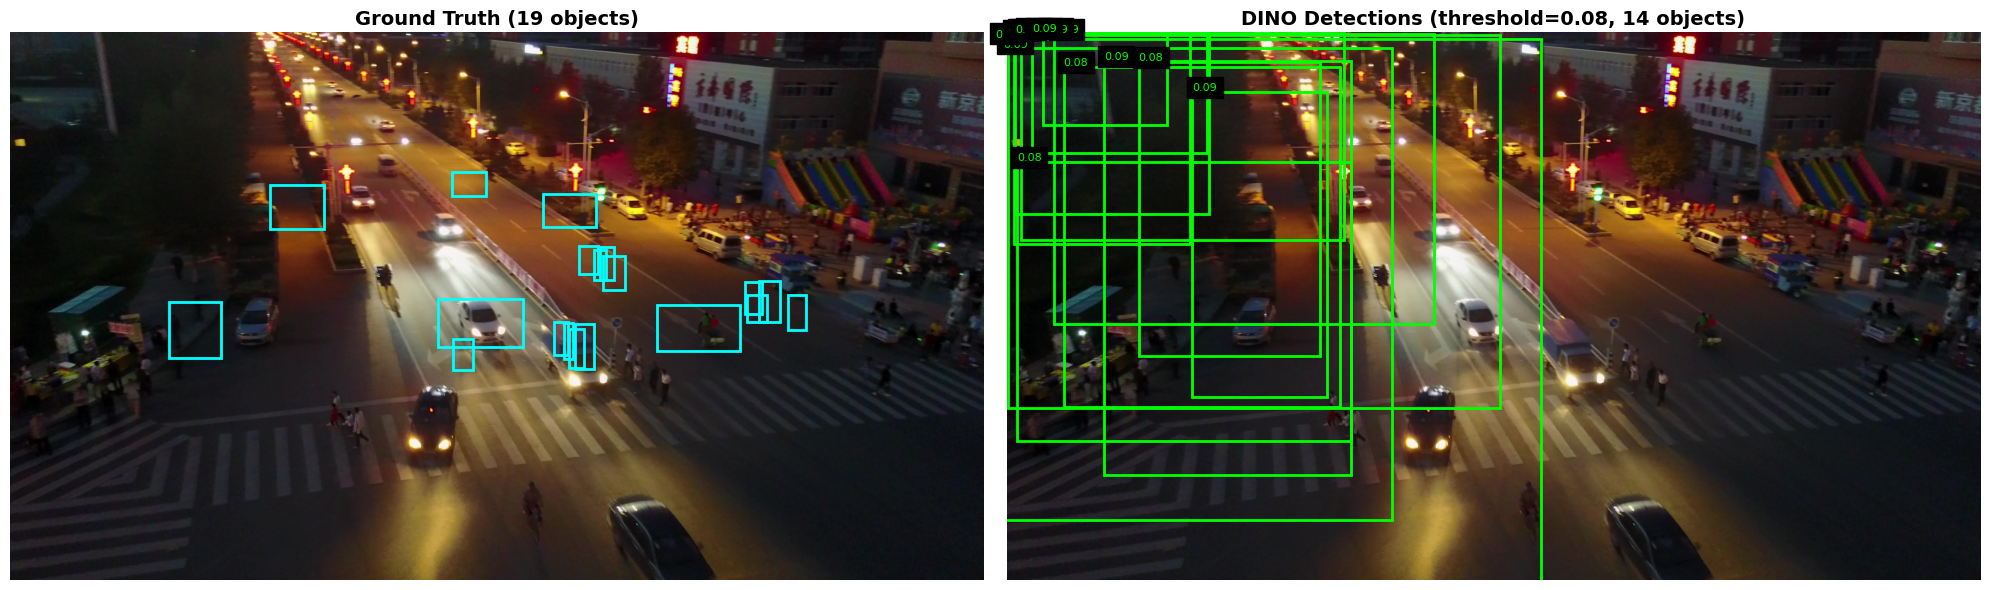

In [26]:
# Cell 12: Visualize with optimal threshold 0.08
thresh_optimal = 0.08

boxes_opt, logits_opt, phrases_opt = predict(
    model=model,
    image=tensor,
    caption="pedestrian. car. van. bus. truck. person. vehicle.",
    box_threshold=thresh_optimal,
    text_threshold=thresh_optimal
)

print(f"Optimal threshold: {thresh_optimal}")
print(f"GT boxes: {len(gt_boxes)}")
print(f"DINO detections: {len(boxes_opt)}")
print(f"Ratio: {len(boxes_opt)/len(gt_boxes):.2f}x")

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Ground Truth
axes[0].imshow(img_rgb)
axes[0].set_title(f'Ground Truth ({len(gt_boxes)} objects)', fontsize=14, fontweight='bold')
for box in gt_boxes:
    x, y, w, h, tid = box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                             edgecolor='cyan', facecolor='none')
    axes[0].add_patch(rect)
axes[0].axis('off')

# Right: DINO with optimal threshold
axes[1].imshow(img_rgb)
axes[1].set_title(f'DINO Detections (threshold={thresh_optimal}, {len(boxes_opt)} objects)', 
                 fontsize=14, fontweight='bold')

H, W = img_rgb.shape[:2]
for box, score in zip(boxes_opt, logits_opt):
    cx, cy, w, h = box
    x1 = (cx - w/2) * W
    y1 = (cy - h/2) * H
    box_w = w * W
    box_h = h * W
    
    rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='lime', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{score:.2f}", color='lime', 
                fontsize=8, backgroundcolor='black')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Cell 13: Analyze what DINO is actually detecting
print("What is DINO detecting?")
print("="*60)

for i, (box, score, phrase) in enumerate(zip(boxes_opt[:20], logits_opt[:20], phrases_opt[:20])):
    cx, cy, w, h = box
    x1 = int((cx - w/2) * W)
    y1 = int((cy - h/2) * H)
    x2 = int((cx + w/2) * W)
    y2 = int((cy + h/2) * H)
    
    area = (x2-x1) * (y2-y1)
    print(f"{i+1:2d}. {phrase:20s} | score: {score:.3f} | bbox: ({x1:4d},{y1:4d},{x2:4d},{y2:4d}) | area: {area:7d}")

# Check phrase distribution
from collections import Counter
phrase_counts = Counter(phrases_opt)
print(f"\n{'='*60}")
print("Phrase distribution:")
for phrase, count in phrase_counts.most_common():
    print(f"  {phrase:20s}: {count:3d}")

What is DINO detecting?
 1. pedestrian vehicle   | score: 0.090 | bbox: ( -11,  44,1077, 785) | area:  806208
 2. pedestrian           | score: 0.084 | bbox: ( 158,  96, 930, 630) | area:  412248
 3. pedestrian           | score: 0.091 | bbox: ( 518, 166, 895, 645) | area:  180583
 4. pedestrian           | score: 0.085 | bbox: ( 368,  82, 875, 543) | area:  233727
 5. pedestrian           | score: 0.088 | bbox: ( 271,  80, 961, 730) | area:  448500
 6. vehicle              | score: 0.088 | bbox: (  19,   3, 513, 334) | area:  163514
 7. pedestrian           | score: 0.081 | bbox: (  27, 361, 962, 800) | area:  410465
 8. pedestrian vehicle   | score: 0.087 | bbox: ( 132,   3,1193, 459) | area:  483816
 9. vehicle              | score: 0.085 | bbox: (  40,   1, 941, 326) | area:  292825
10. vehicle              | score: 0.084 | bbox: ( -32,  16,1493, 980) | area: 1470100
11. vehicle              | score: 0.093 | bbox: (   3,   6,1377, 592) | area:  805164
12. vehicle              | sco

In [28]:
# Cell 18: Test if the boxes are REALLY that big or if it's a display bug
print("Raw DINO output for first detection:")
print(f"  boxes_opt[0] = {boxes_opt[0]}")
print(f"  logits_opt[0] = {logits_opt[0]}")
print(f"  phrases_opt[0] = {phrases_opt[0]}")

# Manual calculation
cx, cy, w, h = boxes_opt[0]
H, W = 1530, 2720

x1_manual = (cx - w/2) * W
y1_manual = (cy - h/2) * H  
x2_manual = (cx + w/2) * W
y2_manual = (cy + h/2) * H

print(f"\nManual pixel conversion:")
print(f"  x1={x1_manual:.1f}, y1={y1_manual:.1f}")
print(f"  x2={x2_manual:.1f}, y2={y2_manual:.1f}")
print(f"  width={x2_manual-x1_manual:.1f}, height={y2_manual-y1_manual:.1f}")
print(f"  area={(x2_manual-x1_manual)*(y2_manual-y1_manual):.0f}")

# Check if box is mostly valid
if w > 0.9 or h > 0.9:
    print(f"\n⚠️  WARNING: Box is {w*100:.0f}% wide and {h*100:.0f}% tall - this is abnormally large!")
    print("   DINO is detecting huge regions, not objects.")

Raw DINO output for first detection:
  boxes_opt[0] = tensor([0.1961, 0.2711, 0.4003, 0.4845])
  logits_opt[0] = 0.09014642238616943
  phrases_opt[0] = pedestrian vehicle

Manual pixel conversion:
  x1=-11.1, y1=44.2
  x2=1077.6, y2=785.4
  width=1088.7, height=741.2
  area=806964


Working sequence: uav0000086_00000_v
Image shape: (756, 1344, 3)


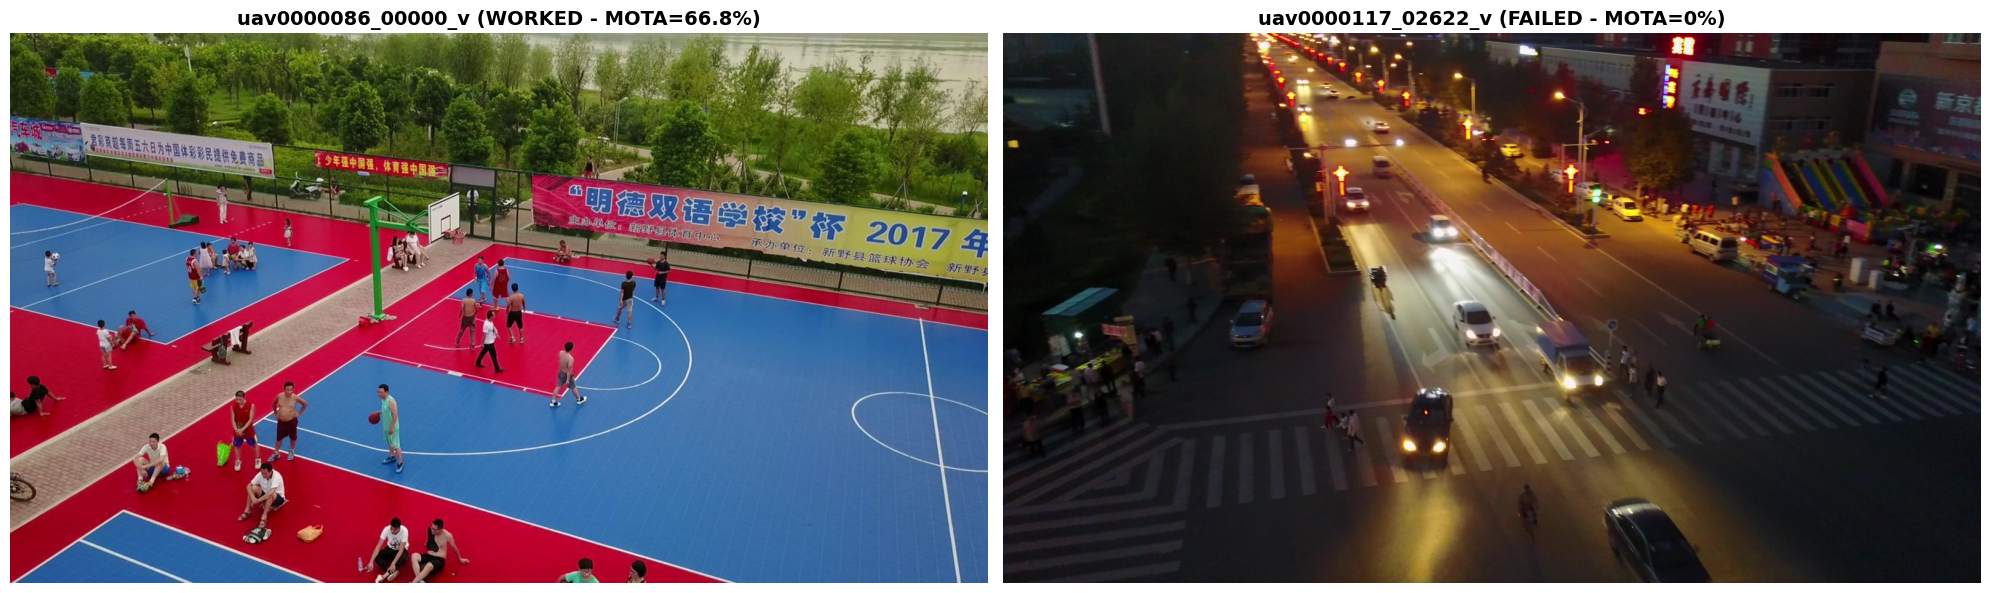

In [29]:
# Cell 19: Load and visualize the WORKING sequence
working_seq = "uav0000086_00000_v"
working_img_path = f"../dataset/visdrone_mot_format/val/{working_seq}/img1/0000001.jpg"
working_img_bgr = cv2.imread(working_img_path)
working_img_rgb = cv2.cvtColor(working_img_bgr, cv2.COLOR_BGR2RGB)

print(f"Working sequence: {working_seq}")
print(f"Image shape: {working_img_bgr.shape}")

# Display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(working_img_rgb)
axes[0].set_title(f'{working_seq} (WORKED - MOTA=66.8%)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_rgb)
axes[1].set_title('uav0000117_02622_v (FAILED - MOTA=0%)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Cell 20: Run DINO on the working sequence
# Transform
working_img_pil = Image.fromarray(working_img_rgb)
working_tensor = transform(working_img_pil).cuda()

print(f"Running DINO on working sequence...")
working_boxes, working_logits, working_phrases = predict(
    model=model,
    image=working_tensor,
    caption="pedestrian. car. van. bus. truck. person. vehicle.",
    box_threshold=0.08,
    text_threshold=0.08
)

print(f"\nWorking sequence detections: {len(working_boxes)}")
print(f"Score range: {working_logits.min():.3f} to {working_logits.max():.3f}")
print(f"Mean score: {working_logits.mean():.3f}")

# Get GT for working sequence
working_gt = []
with open(f"../dataset/visdrone_mot_format/val/{working_seq}/gt/gt.txt") as f:
    for line in f:
        parts = line.strip().split(',')
        if int(parts[0]) == 1:  # Frame 1
            x, y, w, h = map(float, parts[2:6])
            working_gt.append([x, y, w, h])

print(f"Working sequence GT boxes: {len(working_gt)}")

Running DINO on working sequence...

Working sequence detections: 116
Score range: 0.080 to 0.951
Mean score: 0.310
Working sequence GT boxes: 34


In [31]:
# Cell 21: Analyze box sizes for working sequence
working_H, working_W = working_img_rgb.shape[:2]

print("\n" + "="*60)
print("WORKING SEQUENCE - Box size analysis:")
print("="*60)

# DINO boxes
working_dino_areas = []
working_dino_widths = []
working_dino_heights = []

for box in working_boxes:
    cx, cy, w, h = box
    working_dino_widths.append(w.item())
    working_dino_heights.append(h.item())
    area = (w * working_W) * (h * working_H)
    working_dino_areas.append(area.item())

print(f"\nDINO detections:")
print(f"  Box width (normalized):  min={min(working_dino_widths):.3f}, max={max(working_dino_widths):.3f}, mean={np.mean(working_dino_widths):.3f}")
print(f"  Box height (normalized): min={min(working_dino_heights):.3f}, max={max(working_dino_heights):.3f}, mean={np.mean(working_dino_heights):.3f}")
print(f"  Box area (pixels²):      min={min(working_dino_areas):.0f}, max={max(working_dino_areas):.0f}, mean={np.mean(working_dino_areas):.0f}")

# GT boxes
working_gt_areas = [w*h for x,y,w,h in working_gt]
print(f"\nGround Truth:")
print(f"  Box area (pixels²):      min={min(working_gt_areas):.0f}, max={max(working_gt_areas):.0f}, mean={np.mean(working_gt_areas):.0f}")

print("\n" + "="*60)
print("FAILING SEQUENCE - Box size analysis (for comparison):")
print("="*60)

failing_dino_widths = [b[2].item() for b in boxes_opt]
failing_dino_heights = [b[3].item() for b in boxes_opt]

print(f"\nDINO detections:")
print(f"  Box width (normalized):  min={min(failing_dino_widths):.3f}, max={max(failing_dino_widths):.3f}, mean={np.mean(failing_dino_widths):.3f}")
print(f"  Box height (normalized): min={min(failing_dino_heights):.3f}, max={max(failing_dino_heights):.3f}, mean={np.mean(failing_dino_heights):.3f}")


WORKING SEQUENCE - Box size analysis:

DINO detections:
  Box width (normalized):  min=0.009, max=0.063, mean=0.023
  Box height (normalized): min=0.030, max=0.166, mean=0.069
  Box area (pixels²):      min=339, max=7649, mean=1748

Ground Truth:
  Box area (pixels²):      min=540, max=8464, mean=2634

FAILING SEQUENCE - Box size analysis (for comparison):

DINO detections:
  Box width (normalized):  min=0.127, max=0.561, mean=0.292
  Box height (normalized): min=0.094, max=0.630, mean=0.307


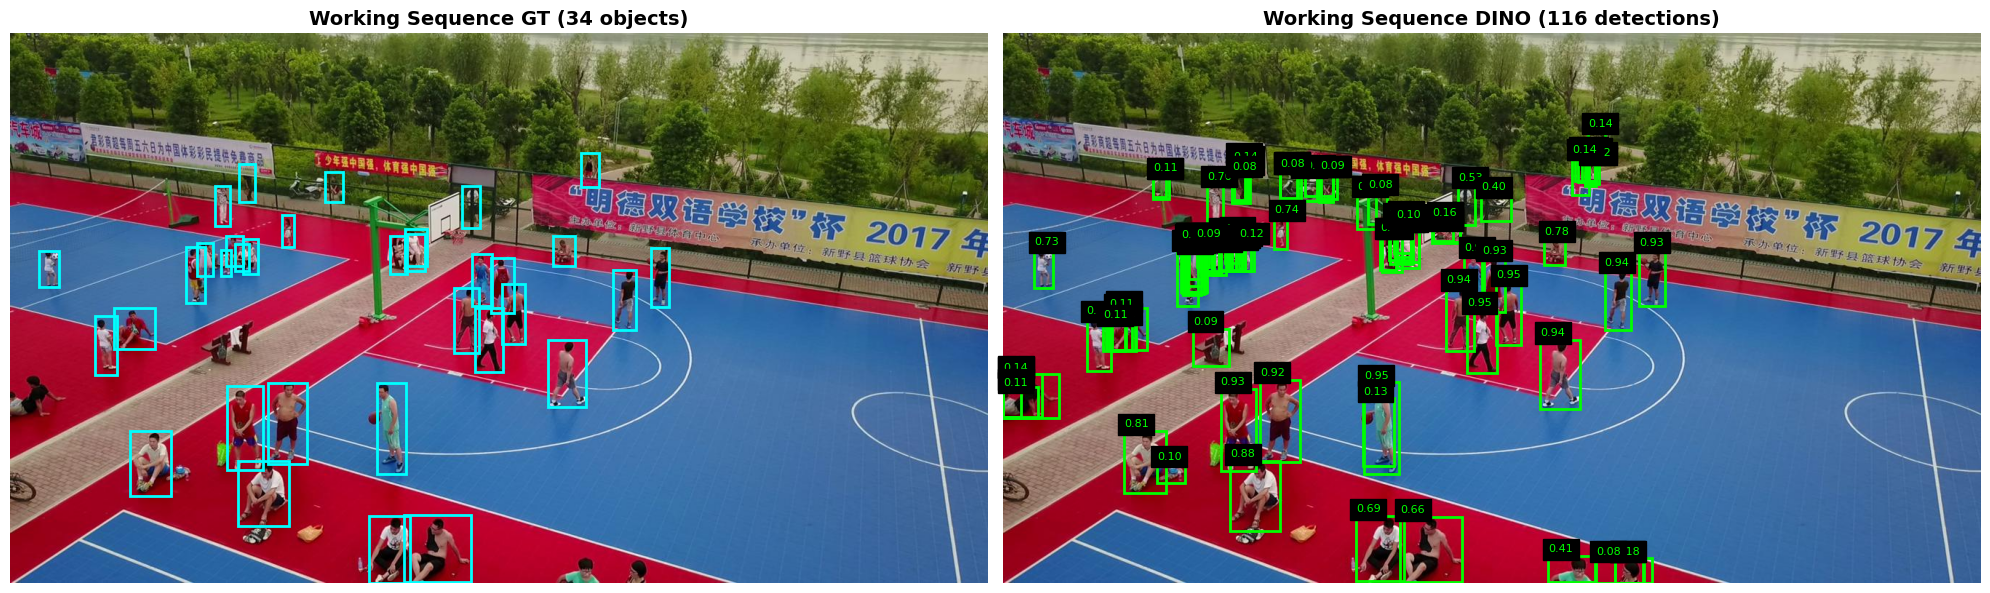

In [32]:
# Cell 22: Visualize working sequence detections
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Ground Truth
axes[0].imshow(working_img_rgb)
axes[0].set_title(f'Working Sequence GT ({len(working_gt)} objects)', fontsize=14, fontweight='bold')
for box in working_gt[:100]:
    x, y, w, h = box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                             edgecolor='cyan', facecolor='none')
    axes[0].add_patch(rect)
axes[0].axis('off')

# Right: DINO Detections
axes[1].imshow(working_img_rgb)
axes[1].set_title(f'Working Sequence DINO ({len(working_boxes)} detections)', fontsize=14, fontweight='bold')

for box, score in zip(working_boxes[:100], working_logits[:100]):
    cx, cy, w, h = box
    x1 = (cx - w/2) * working_W
    y1 = (cy - h/2) * working_H
    box_w = w * working_W
    box_h = h * working_H
    
    rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='lime', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{score:.2f}", color='lime', 
                fontsize=8, backgroundcolor='black')
axes[1].axis('off')

plt.tight_layout()
plt.show()